# Car Make and Model Recognition using CNN

**Description:** A Jupyter notebook detailing the process of building, training, evaluating, and deploying a Convolutional Neural Network (CNN) for recognizing car makes and models.

## Phase 0: Preparation and Initial Setup

Set up the environment, select the dataset, and organize the data into a clear folder structure.

In [1]:
# Import necessary libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns
import scipy.io
import shutil
import glob
from sklearn.model_selection import train_test_split
import pathlib

# Define constants
# DATASET_PATH = 'path/to/your/car_dataset' # Original placeholder
ORGANIZED_DATASET_PATH = './organized_cars_dataset'
ORIGINAL_TRAIN_PATH = './cars_train/cars_train'
ORIGINAL_TEST_PATH = './cars_test/cars_test'
ANNOTATIONS_FILE = './cars_annos.mat'
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3
BATCH_SIZE = 32
EPOCHS_SCRATCH = 25
EPOCHS_AUGMENTED = 30
EPOCHS_TRANSFER = 15
EPOCHS_FINE_TUNE = 10
# NUM_CLASSES = 196 # Will be determined from annotations
VALIDATION_SPLIT = 0.2 # 20% of training data for validation
RANDOM_SEED = 42

# Ensure original dataset paths exist (conceptual check)
# if not os.path.exists(ORIGINAL_TRAIN_PATH) or not os.path.exists(ORIGINAL_TEST_PATH):
#     raise FileNotFoundError(f"Original dataset folders not found.")
# if not os.path.exists(ANNOTATIONS_FILE):
#     raise FileNotFoundError(f"Annotations file not found at {ANNOTATIONS_FILE}")

print("TensorFlow Version:", tf.__version__)
# Add GPU check if relevant
# print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

TensorFlow Version: 2.19.0


In [2]:
# Check for GPU availability
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
else:
    print("No GPU detected. Running on CPU.")

No GPU detected. Running on CPU.


### Data Loading, Parsing, and Organization

Load annotations, create train/validation/test splits with class folders.

In [3]:
import scipy.io
import os
import pathlib
import shutil
import glob
from sklearn.model_selection import train_test_split
import numpy as np # Assuming numpy might be needed elsewhere or for completeness

# Define Dummy Paths/Variables for execution context (replace with your actual variables)
# Ensure these paths exist and point to the correct locations in your environment
ANNOTATIONS_FILE = r'C:\Car Make and Model Recognition\cars_annos.mat'
ORIGINAL_TEST_PATH = r'C:\Car Make and Model Recognition\cars_test\cars_test' # Verify this inner cars_test folder exists!
ORIGINAL_TRAIN_PATH = r'C:\Car Make and Model Recognition\cars_train\cars_train' # Verify this inner cars_train folder exists!
ORGANIZED_DATASET_PATH = r'C:\Car Make and Model Recognition\organized_cars_dataset'

VALIDATION_SPLIT = 0.2
RANDOM_SEED = 42

# --- Create dummy files/dirs if they don't exist (for testing purposes) ---
# You should REMOVE or COMMENT OUT this section when running with your actual data
if not os.path.exists(ANNOTATIONS_FILE):
    print(f"Warning: Dummy annotation file created at {ANNOTATIONS_FILE}. Replace with your actual file.")
    os.makedirs(os.path.dirname(ANNOTATIONS_FILE) or '.', exist_ok=True)
    # Create a minimal dummy .mat file structure
    # Note: This dummy structure assumes the filename is stored as a numpy array containing a string
    dummy_annos = {
        'annotations': np.array([[(np.array([[1]]), np.array([[1]]), np.array([[10]]), np.array([[10]]), np.array([[1]]), np.array(['cars_train/00001.jpg'], dtype=object)) , \
                                 (np.array([[1]]), np.array([[1]]), np.array([[10]]), np.array([[10]]), np.array([[2]]), np.array(['cars_train/00002.jpg'], dtype=object)) , \
                                 (np.array([[1]]), np.array([[1]]), np.array([[10]]), np.array([[10]]), np.array([[1]]), np.array(['cars_test/00003.jpg'], dtype=object)) , \
                                 (np.array([[1]]), np.array([[1]]), np.array([[10]]), np.array([[10]]), np.array([[2]]), np.array(['cars_test/00004.jpg'], dtype=object)) \
                                ]], dtype=object),
        'class_names': np.array([[(np.array(['Class A'], dtype=object)), (np.array(['Class B'], dtype=object))]], dtype=object)
    }
    scipy.io.savemat(ANNOTATIONS_FILE, dummy_annos)

if not os.path.exists(ORIGINAL_TRAIN_PATH):
    print(f"Warning: Dummy train directory created at {ORIGINAL_TRAIN_PATH}.")
    os.makedirs(ORIGINAL_TRAIN_PATH, exist_ok=True)
    # Create dummy files
    with open(os.path.join(ORIGINAL_TRAIN_PATH, '00001.jpg'), 'w') as f: f.write('dummy')
    with open(os.path.join(ORIGINAL_TRAIN_PATH, '00002.jpg'), 'w') as f: f.write('dummy')
    with open(os.path.join(ORIGINAL_TRAIN_PATH, 'other.txt'), 'w') as f: f.write('dummy') # Non-jpg

if not os.path.exists(ORIGINAL_TEST_PATH):
    print(f"Warning: Dummy test directory created at {ORIGINAL_TEST_PATH}.")
    os.makedirs(ORIGINAL_TEST_PATH, exist_ok=True)
    # Create dummy files
    with open(os.path.join(ORIGINAL_TEST_PATH, '00003.jpg'), 'w') as f: f.write('dummy')
    with open(os.path.join(ORIGINAL_TEST_PATH, '00004.jpg'), 'w') as f: f.write('dummy')
# --- End of Dummy Setup ---


# Load annotations
print(f"Loading annotations from: {ANNOTATIONS_FILE}")
if not os.path.exists(ANNOTATIONS_FILE):
    raise FileNotFoundError(f"Annotation file not found at {ANNOTATIONS_FILE}")
mat_contents = scipy.io.loadmat(ANNOTATIONS_FILE)
annotations = mat_contents['annotations'][0]
class_names = [name[0] for name in mat_contents['class_names'][0]]
NUM_CLASSES = len(class_names)
print(f"Found {NUM_CLASSES} classes.")

# Create mapping: filename -> class_id (adjusting for 1-based indexing in MAT)
file_to_class = {}
print("Processing annotations to create filename -> class_id map...")

for item in annotations:
    try:
        # Access filename using the field name 'relative_im_path'
        raw_filename_array = item['relative_im_path']
        if raw_filename_array.size > 0:
             raw_filename = raw_filename_array[0] # Get the element (string or bytes) from the array
        else:
             print(f"Warning: item['relative_im_path'] is empty for an annotation item. Skipping.")
             continue # Skip this annotation item

        # Decode bytes to string if necessary (common for strings loaded from .mat files)
        if isinstance(raw_filename, (bytes, np.bytes_)):
             raw_filename = raw_filename.decode('utf-8')
        elif not isinstance(raw_filename, str):
             # Fallback or warning if it's neither bytes nor str - investigate with debug prints
             print(f"Warning: Expected filename to be string or bytes, but got {type(raw_filename)}. Skipping.")
             continue

        # Get the raw basename (e.g., '000001.jpg')
        raw_basename = os.path.basename(raw_filename)
        name_part, ext_part = os.path.splitext(raw_basename)

        # Normalize to 5 digits (e.g., '00001.jpg') to match disk files
        try:
            # Ensure it's a numeric filename before formatting
            base_filename = f"{int(name_part):05d}{ext_part.lower()}"
        except ValueError:
            # If the name isn't purely numeric, use the raw basename
            print(f"Warning: Filename '{raw_basename}' is not purely numeric, using it as is.")
            base_filename = raw_basename

        # Access class ID using the field name 'class'
        # Adjust for 0-based indexing (MATLAB is 1-based)
        class_id = item['class'][0][0] - 1

        file_to_class[base_filename] = class_id
    except IndexError as e:
        print(f"Warning: Skipping annotation item due to unexpected structure or index error: {item}. Error: {e}")
    except KeyError as e:
        print(f"Warning: Skipping annotation item due to missing key '{e}'. Check .mat file structure.")
    except Exception as e:
        # Catch potential errors during filename processing or class_id extraction
        print(f"Warning: Skipping annotation item due to unexpected error processing filename or class_id. Item structure snapshot: {item}. Error: {e}")

print(f"Created file_to_class map with {len(file_to_class)} entries.")
if file_to_class:
    # Print the first key to confirm it looks like a 5-digit filename
    print(f"Example annotation key (normalized): '{list(file_to_class.keys())[0]}'")
else:
    print("Warning: file_to_class map is empty after processing. Check annotation file structure and content.")

# Function to create directories and copy files
def organize_files(file_list, source_dir, target_base_dir, class_names_map, file_to_class_map):
    print(f"Organizing {len(file_list)} files from {source_dir} into {target_base_dir}...")
    # Ensure the base target directory exists *before* trying to create class subdirs
    pathlib.Path(target_base_dir).mkdir(parents=True, exist_ok=True)
    copied_count = 0
    skipped_count = 0
    skipped_annotation_not_found = 0
    skipped_source_not_found = 0

    # Check if file_to_class_map is empty
    if not file_to_class_map:
        print(f"Warning: Cannot organize files because the file_to_class map is empty.")
        return # Exit function early

    for filename_or_path in file_list: # Input might be full path or just basename
        basename = os.path.basename(filename_or_path)
        if basename in file_to_class_map:
            try:
                class_id = file_to_class_map[basename]
                if 0 <= class_id < len(class_names_map):
                    class_name = class_names_map[class_id]
                    # Sanitize class name for directory creation
                    safe_class_name = class_name.replace('/', '_').replace(' ', '_').replace('-', '_') # Added hyphen replacement
                    target_class_dir = os.path.join(target_base_dir, safe_class_name)
                    pathlib.Path(target_class_dir).mkdir(parents=True, exist_ok=True)

                    # Important: Construct source path using the original source_dir and the basename
                    source_path = os.path.join(source_dir, basename)
                    target_path = os.path.join(target_class_dir, basename)

                    if os.path.exists(source_path):
                        try:
                            # Use copy2 to preserve metadata like timestamp if needed
                            shutil.copy2(source_path, target_path)
                            copied_count += 1
                        except Exception as e:
                            print(f"Error copying {source_path} to {target_path}: {e}")
                            skipped_count += 1
                    else:
                        # This condition might be hit if file_list contained paths from a different location than source_dir
                        print(f"Warning: Source file not found at expected location: {source_path}")
                        skipped_source_not_found += 1
                        skipped_count += 1
                else:
                    print(f"Warning: Invalid class_id {class_id} found for {basename}. Max index: {len(class_names_map)-1}")
                    skipped_count += 1
            except Exception as e:
                 # Catch errors during class_id lookup or path construction
                 print(f"Error processing file {basename} with class_id lookup or pathing: {e}")
                 skipped_count += 1
        else:
            # This is expected if file_list contains files not in annotations (e.g., from glob results before filtering)
            # print(f"Debug: Annotation not found for {basename}") # Less verbose, comment out if not needed
            skipped_annotation_not_found += 1
            skipped_count += 1
    print(f"Finished organizing for {target_base_dir}. Copied: {copied_count}, Skipped Total: {skipped_count} (Annotation Not Found: {skipped_annotation_not_found}, Source Not Found: {skipped_source_not_found})")

# Function to normalize filenames for consistent matching between disk files and annotations
def normalize_filename(filename):
    """Normalize a filename to match the format in file_to_class (5 digits for car dataset)"""
    name, ext = os.path.splitext(filename)
    try:
        # Try to convert to integer and format with 5 digits
        return f"{int(name):05d}{ext.lower()}"
    except ValueError:
        # If conversion fails, return the original filename
        return filename.lower()

# --- Organize Test Data ---
print("\n--- Organizing Test Data ---")
print(f"Looking for test images in: {ORIGINAL_TEST_PATH}")
if not os.path.isdir(ORIGINAL_TEST_PATH):
    print(f"Warning: Original test path {ORIGINAL_TEST_PATH} does not exist or is not a directory.")
    test_files_full_paths = []
else:
    test_files_full_paths = glob.glob(os.path.join(ORIGINAL_TEST_PATH, '*.jpg'))
print(f"Found {len(test_files_full_paths)} .jpg files in the test directory.")
# We pass only the basenames to organize_files, as it expects a list of filenames to look up in the map
test_basenames = [os.path.basename(f) for f in test_files_full_paths]
test_target_dir = os.path.join(ORGANIZED_DATASET_PATH, 'test')
organize_files(test_basenames, ORIGINAL_TEST_PATH, test_target_dir, class_names, file_to_class)

# --- Organize Train/Validation Data ---
print("\n--- Organizing Train/Validation Data ---")
print(f"Looking for training images in: {ORIGINAL_TRAIN_PATH}")
if not os.path.isdir(ORIGINAL_TRAIN_PATH):
    print(f"Warning: Original train path {ORIGINAL_TRAIN_PATH} does not exist or is not a directory.")
    all_train_files_basenames_initial = []
else:
    # Use the normalize_filename function to ensure consistent formatting
    all_train_files_basenames_initial = [os.path.basename(f) for f in glob.glob(os.path.join(ORIGINAL_TRAIN_PATH, '*.jpg'))]
print(f"Found {len(all_train_files_basenames_initial)} .jpg files initially in the train directory.")

# Print some examples to help debug
if all_train_files_basenames_initial:
    print("Examples of disk filenames:")
    for i, f in enumerate(all_train_files_basenames_initial[:5]):
        print(f"  {i+1}. Original: '{f}', Normalized: '{normalize_filename(f)}'")

if file_to_class:
    print("Examples of annotation keys:")
    for i, k in enumerate(list(file_to_class.keys())[:5]):
        print(f"  {i+1}. '{k}'")

# Filter files that match keys in file_to_class (using normalization)
all_train_files_basenames_filtered = []
for f in all_train_files_basenames_initial:
    # Try both the original filename and the normalized version
    if f in file_to_class:
        all_train_files_basenames_filtered.append(f)
    else:
        # Try normalizing the filename to match annotation format
        normalized_f = normalize_filename(f)
        if normalized_f in file_to_class:
            all_train_files_basenames_filtered.append(normalized_f)

print(f"Filtered to {len(all_train_files_basenames_filtered)} train files present in annotations.")

if not all_train_files_basenames_filtered:
    print("Error: No training files found that match the annotations. Cannot proceed with splitting and organizing training data.")
    # More detailed debug information
    print("\nFORMAT MISMATCH TROUBLESHOOTING:")
    print("1. Check if disk filenames need padding to 5 digits (e.g., '1.jpg' → '00001.jpg')")
    print("2. Check if annotations use different path format (e.g., 'cars_train/00001.jpg' vs '00001.jpg')")
    print("3. Manually inspect the first few files in both directories to confirm format")
    print("4. Consider manually renaming files to match annotation format if needed")
    
    # FALLBACK: If we have disk files but no matches, try a more aggressive matching approach
    print("\nAttempting fallback approach with class ID assignment...")
    # Check if we have enough annotations to cover the classes
    if len(file_to_class) > 0 and all_train_files_basenames_initial:
        print(f"Found {len(all_train_files_basenames_initial)} files but couldn't match to annotations.")
        print("Using first N class IDs for first N images (FOR DEMONSTRATION PURPOSES ONLY!)")
        # This is just a demonstration fallback - not ideal for real use!
        all_train_files_basenames_filtered = all_train_files_basenames_initial[:min(len(all_train_files_basenames_initial), NUM_CLASSES*5)]
        print(f"Proceeding with {len(all_train_files_basenames_filtered)} arbitrary files.")

# Proceed with splitting and organizing if we have filtered files
if all_train_files_basenames_filtered:
    # Create labels corresponding to the filtered list
    try:
        # For regular files that matched annotations
        train_labels = []
        for f in all_train_files_basenames_filtered:
            if f in file_to_class:
                train_labels.append(file_to_class[f])
            else:
                # For fallback mode - assign sequential class IDs (0, 1, 2...) if needed
                class_id = len(train_labels) % NUM_CLASSES
                train_labels.append(class_id)
                # Also add to file_to_class for the organize_files function
                file_to_class[f] = class_id
    except KeyError as e:
        print(f"Error: A key '{e}' was expected in file_to_class but not found during label creation. This shouldn't happen after filtering. Check logic.")
        train_labels = [] # Prevent further errors

    if train_labels: # Proceed only if we have labels
        # Check if validation split makes sense
        if len(all_train_files_basenames_filtered) > 0 and len(all_train_files_basenames_filtered) * VALIDATION_SPLIT < 1 and VALIDATION_SPLIT > 0:
             print(f"Warning: Dataset size ({len(all_train_files_basenames_filtered)}) is too small for validation split ({VALIDATION_SPLIT}). The validation set might be empty or contain only one sample.")

        # Split train into train and validation
        print(f"Attempting to split {len(all_train_files_basenames_filtered)} files...")
        try:
            train_files, val_files, train_labels_split, val_labels_split = train_test_split(
                all_train_files_basenames_filtered, # Use the filtered list
                train_labels,                     # Use the corresponding labels
                test_size=VALIDATION_SPLIT,
                random_state=RANDOM_SEED,
                stratify=train_labels # Ensure class distribution is similar in train/val
            )
            print(f"Splitting original training data successful: {len(train_files)} train, {len(val_files)} validation")

            # Organize the split training files
            train_target_dir = os.path.join(ORGANIZED_DATASET_PATH, 'train')
            organize_files(train_files, ORIGINAL_TRAIN_PATH, train_target_dir, class_names, file_to_class)

            # Organize the split validation files
            val_target_dir = os.path.join(ORGANIZED_DATASET_PATH, 'validation')
            organize_files(val_files, ORIGINAL_TRAIN_PATH, val_target_dir, class_names, file_to_class)

        except ValueError as e:
            print(f"Error during train_test_split: {e}")
            print("This might happen if the filtered dataset is too small or if stratify fails due to too few members in a class.")

    else:
         print("Skipping train/validation split because label creation failed or resulted in no labels.")


print("\nData organization process complete.")

# Verify organized directories
print("\nVerifying organized directories...")
train_dir_check = os.path.join(ORGANIZED_DATASET_PATH, 'train')
val_dir_check = os.path.join(ORGANIZED_DATASET_PATH, 'validation')
test_dir_check = os.path.join(ORGANIZED_DATASET_PATH, 'test')

if not os.path.isdir(train_dir_check):
    print(f"Status: Training directory {train_dir_check} does not exist.")
elif not os.listdir(train_dir_check):
    print(f"Warning: Training directory {train_dir_check} exists but is empty.")
else:
    # Further check: see if it contains subdirectories (classes)
    subdirs = [d for d in os.listdir(train_dir_check) if os.path.isdir(os.path.join(train_dir_check, d))]
    if subdirs:
        print(f"Status: Training directory {train_dir_check} looks okay and contains {len(subdirs)} class subdirectories.")
    else:
         print(f"Warning: Training directory {train_dir_check} exists but contains no class subdirectories.")


if not os.path.isdir(val_dir_check):
    print(f"Status: Validation directory {val_dir_check} does not exist.")
elif not os.listdir(val_dir_check):
    print(f"Warning: Validation directory {val_dir_check} exists but is empty.")
else:
    # Further check: see if it contains subdirectories (classes)
    subdirs = [d for d in os.listdir(val_dir_check) if os.path.isdir(os.path.join(val_dir_check, d))]
    if subdirs:
        print(f"Status: Validation directory {val_dir_check} looks okay and contains {len(subdirs)} class subdirectories.")
    else:
         print(f"Warning: Validation directory {val_dir_check} exists but contains no class subdirectories.")


if not os.path.isdir(test_dir_check):
    print(f"Status: Test directory {test_dir_check} does not exist.")
elif not os.listdir(test_dir_check):
    print(f"Warning: Test directory {test_dir_check} exists but is empty.")
else:
     # Further check: see if it contains subdirectories (classes)
    subdirs = [d for d in os.listdir(test_dir_check) if os.path.isdir(os.path.join(test_dir_check, d))]
    if subdirs:
        print(f"Status: Test directory {test_dir_check} looks okay and contains {len(subdirs)} class subdirectories.")
    else:
         print(f"Warning: Test directory {test_dir_check} exists but contains no class subdirectories.")

Loading annotations from: C:\Car Make and Model Recognition\cars_annos.mat
Found 196 classes.
Processing annotations to create filename -> class_id map...
Created file_to_class map with 16185 entries.
Example annotation key (normalized): '00001.jpg'

--- Organizing Test Data ---
Looking for test images in: C:\Car Make and Model Recognition\cars_test\cars_test
Found 2 .jpg files in the test directory.
Organizing 2 files from C:\Car Make and Model Recognition\cars_test\cars_test into C:\Car Make and Model Recognition\organized_cars_dataset\test...
Finished organizing for C:\Car Make and Model Recognition\organized_cars_dataset\test. Copied: 2, Skipped Total: 0 (Annotation Not Found: 0, Source Not Found: 0)

--- Organizing Train/Validation Data ---
Looking for training images in: C:\Car Make and Model Recognition\cars_train\cars_train
Found 2 .jpg files initially in the train directory.
Examples of disk filenames:
  1. Original: '00001.jpg', Normalized: '00001.jpg'
  2. Original: '00002.j

### Data Loading and Preprocessing (Using Generators)

Set up ImageDataGenerators to load images from the organized directories.

In [4]:
# Define the CNN model architecture 'from scratch'
def build_scratch_model(input_shape, num_classes):
    model = keras.Sequential(
        [
            keras.Input(shape=input_shape),
            layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dropout(0.5),
            layers.Dense(512, activation="relu"),
            layers.Dense(num_classes, activation="softmax"),
        ]
    )
    return model

input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)

In [5]:
# Data generators (without augmentation for initial setup)
# Assuming data is organized in train/validation/test folders with subfolders for each class

PROJECT_ROOT = 'C:\\Car Make and Model Recognition'

train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

print("Creating train generator...")
train_generator = train_datagen.flow_from_directory(
    os.path.join(ORGANIZED_DATASET_PATH, 'train'), # <-- Point to the organized train data
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical', # Keep categorical for one-hot encoding
    seed=RANDOM_SEED
)
print(f"Train generator found {train_generator.samples} images belonging to {train_generator.num_classes} classes.")

# Determine NUM_CLASSES *from the training data*
NUM_CLASSES = train_generator.num_classes
print(f"Setting NUM_CLASSES based on train generator: {NUM_CLASSES}")

# Build the model *using this NUM_CLASSES*
print(f"Building scratch model with {NUM_CLASSES} classes...")
model_scratch = build_scratch_model(input_shape, NUM_CLASSES)
print(f"Model built. Output layer units: {model_scratch.layers[-1].units}") # Verify immediately

# Compile the model
print("Compiling model...")
model_scratch.compile(loss="categorical_crossentropy",
                      optimizer="adam",
                      metrics=["accuracy"])
print("Model compiled.")

# Create other generators
print("Creating validation generator...")
validation_generator = validation_datagen.flow_from_directory(
    os.path.join(ORGANIZED_DATASET_PATH, 'validation'), # <-- Point to the organized validation data
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical', # Keep categorical for one-hot encoding
    shuffle=False,
    seed=RANDOM_SEED
)
print(f"Validation generator found {validation_generator.samples} images belonging to {validation_generator.num_classes} classes.")

print("Creating test generator...")
test_generator = test_datagen.flow_from_directory(
    os.path.join(ORGANIZED_DATASET_PATH, 'test'), # This path was already correct
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical', # Keep categorical for one-hot encoding
    shuffle=False,
    seed=RANDOM_SEED
)
print(f"Test generator found {test_generator.samples} images belonging to {test_generator.num_classes} classes.")

# Final verification
print("\n--- Generator Class Count Verification ---")
print(f"Model output layer units: {model_scratch.layers[-1].units}")
print(f"Train generator classes: {train_generator.num_classes}")
print(f"Validation generator classes: {validation_generator.num_classes}")
print(f"Test generator classes: {test_generator.num_classes}")

if not (model_scratch.layers[-1].units == train_generator.num_classes == validation_generator.num_classes == test_generator.num_classes):
     print("\n*** WARNING: Class count mismatch detected between model and/or generators! ***")
     print("Check the organized data folders (train/validation/test) for consistent class subdirectories.")
else:
    print("\nClass counts are consistent across model and generators.")

# Store class indices (optional, but good practice)
class_indices = train_generator.class_indices
# print("Class Indices:", class_indices)

Creating train generator...
Found 1 images belonging to 1 classes.
Train generator found 1 images belonging to 1 classes.
Setting NUM_CLASSES based on train generator: 1
Building scratch model with 1 classes...
Model built. Output layer units: 1
Compiling model...
Model compiled.
Creating validation generator...
Found 1 images belonging to 1 classes.
Validation generator found 1 images belonging to 1 classes.
Creating test generator...
Found 2 images belonging to 1 classes.
Test generator found 2 images belonging to 1 classes.

--- Generator Class Count Verification ---
Model output layer units: 1
Train generator classes: 1
Validation generator classes: 1
Test generator classes: 1

Class counts are consistent across model and generators.


In [6]:
# Diagnose potential class mismatch issues between generators and model
print("Diagnosing model and dataset class consistency...")
print(f"Model output layer size (expected classes): {model_scratch.layers[-1].units}")
print(f"Train generator classes found: {train_generator.num_classes}")
print(f"Validation generator classes found: {validation_generator.num_classes}")
print(f"Test generator classes found: {test_generator.num_classes}")

# Define checkpoint path and directory (ensure it's defined before use in callbacks)
checkpoint_path_scratch = "training_checkpoints/scratch/cp-{epoch:04d}.weights.h5"
checkpoint_dir_scratch = os.path.dirname(checkpoint_path_scratch)
os.makedirs(checkpoint_dir_scratch, exist_ok=True) # Ensure directory exists

# Check for inconsistencies, but DO NOT rebuild the model here.
# The model structure should be based on the training data (set in the previous cell).
model_classes = model_scratch.layers[-1].units
if model_classes != train_generator.num_classes:
    print("\nERROR: Model was built with a different number of classes ({}) than the training generator found ({}).".format(model_classes, train_generator.num_classes))
    print("Please check the cell where the model is built (ID: 6fbcab80) and ensure NUM_CLASSES is set correctly based on train_generator.")
    # raise ValueError("Model class count mismatch with training data.") # Optional: Stop execution
elif model_classes != validation_generator.num_classes:
    print("\nWarning: Validation generator found a different number of classes ({}) than the model expects ({}).".format(validation_generator.num_classes, model_classes))
    print("This might lead to issues during validation.")
elif model_classes != test_generator.num_classes:
    print("\nWarning: Test generator found a different number of classes ({}) than the model expects ({}).".format(test_generator.num_classes, model_classes))
    print("This might lead to issues during evaluation.")
else:
    print("\nModel class count ({}) is consistent with all data generators.".format(model_classes))

Diagnosing model and dataset class consistency...
Model output layer size (expected classes): 1
Train generator classes found: 1
Validation generator classes found: 1
Test generator classes found: 1

Model class count (1) is consistent with all data generators.


In [7]:
# --- Checkpoint Directory Diagnostics ---
import os

# Ensure checkpoint_dir_scratch is defined (it should be from the previous cell)
try:
    abs_checkpoint_dir = os.path.abspath(checkpoint_dir_scratch)
    print(f"Checking for checkpoints in directory: {abs_checkpoint_dir}")
    
    if os.path.isdir(abs_checkpoint_dir):
        print("Directory exists.")
        print("Files in directory:")
        files_in_dir = os.listdir(abs_checkpoint_dir)
        if not files_in_dir:
            print("  (Directory is empty)")
        else:
            for f in files_in_dir:
                print(f"  - {f}")
        # Specifically check for the 'checkpoint' index file
        if 'checkpoint' in files_in_dir:
             print("\nFound 'checkpoint' index file.")
        else:
             print("\n*** WARNING: 'checkpoint' index file NOT FOUND. tf.train.latest_checkpoint needs this file. ***")
    else:
        print("*** ERROR: Checkpoint directory does NOT exist. ***")
except NameError:
    print("*** ERROR: 'checkpoint_dir_scratch' variable not defined before this cell. Check cell ID 0d08399b. ***")
except Exception as e:
    print(f"An unexpected error occurred during checkpoint diagnostics: {e}")

# --- End Checkpoint Directory Diagnostics ---

Checking for checkpoints in directory: c:\Car Make and Model Recognition\training_checkpoints\scratch
Directory exists.
Files in directory:
  - checkpoint
  - cp-0001.weights.h5
  - cp-0002.weights.h5
  - cp-0003.weights.h5
  - cp-0004.weights.h5
  - cp-0005.weights.h5
  - cp-0006.weights.h5
  - cp-0007.weights.h5
  - cp-0008.weights.h5
  - cp-0009.weights.h5
  - cp-0010.weights.h5
  - cp-0011.weights.h5
  - cp-0012.weights.h5
  - cp-0013.weights.h5
  - cp-0014.weights.h5
  - cp-0015.weights.h5
  - cp-0016.weights.h5
  - cp-0017.weights.h5
  - cp-0018.weights.h5
  - cp-0019.weights.h5
  - cp-0020.weights.h5
  - cp-0021.weights.h5
  - cp-0022.weights.h5
  - cp-0023.weights.h5
  - cp-0024.weights.h5
  - cp-0025.weights.h5

Found 'checkpoint' index file.


In [8]:
# Train the model with checkpointing
import os

# Define a callback to save the model's weights
cp_callback_scratch = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path_scratch,
    save_weights_only=True,
    verbose=1,
    save_freq='epoch'
)

# Load the latest checkpoint if it exists
latest_checkpoint_scratch = tf.train.latest_checkpoint(checkpoint_dir_scratch)
if latest_checkpoint_scratch:
    print(f'Loading weights from checkpoint: {latest_checkpoint_scratch}')
    model_scratch.load_weights(latest_checkpoint_scratch)
    print('Model weights loaded. Skipping training.')
    # Assign None to history if training is skipped to avoid errors in the plotting cell
    history_scratch = None 
else:
    print('No checkpoint found. Starting training from scratch.')
    # Train the model only if no checkpoint was found
    print("Training model from scratch...")
    history_scratch = model_scratch.fit(
        train_generator,
        epochs=EPOCHS_SCRATCH,
        validation_data=validation_generator,
        steps_per_epoch=train_generator.samples // BATCH_SIZE,
        validation_steps=validation_generator.samples // BATCH_SIZE,
        callbacks=[cp_callback_scratch]
    )

Loading weights from checkpoint: training_checkpoints/scratch\cp-0025.weights.h5


c:\Car Make and Model Recognition\.venv\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


ValueError: A total of 1 objects could not be loaded. Example error message for object <Dense name=dense_1, built=True>:

The shape of the target variable and the shape of the target value in `variable.assign(value)` must match. variable.shape=(512, 1), Received: value.shape=(512, 100). Target variable: <Variable path=sequential/dense_1/kernel, shape=(512, 1), dtype=float32, value=[[-7.17324093e-02]
 [ 2.66178772e-02]
 [-9.73374248e-02]
 [-6.02010041e-02]
 [ 6.58015385e-02]
 [-8.85648504e-02]
 [ 1.07910372e-01]
 [ 7.82205686e-02]
 [ 7.49293193e-02]
 [-5.70452772e-02]
 [ 3.40873376e-02]
 [ 1.06519245e-01]
 [ 3.70621905e-02]
 [ 1.85379386e-03]
 [-9.21822190e-02]
 [ 4.39137146e-02]
 [ 8.82288590e-02]
 [ 2.53453925e-02]
 [ 1.02747761e-01]
 [ 5.29838726e-02]
 [ 7.35710636e-02]
 [ 6.74323216e-02]
 [ 1.01694919e-01]
 [ 4.27772030e-02]
 [ 5.37804291e-02]
 [ 7.14557618e-03]
 [ 2.78019533e-02]
 [-8.17765445e-02]
 [-9.09749418e-02]
 [ 3.33997980e-02]
 [-6.19064905e-02]
 [ 1.88321844e-02]
 [ 6.82951882e-02]
 [-6.17094971e-02]
 [ 1.69125199e-03]
 [-3.80754918e-02]
 [-8.52925256e-02]
 [ 1.32235289e-02]
 [-3.87116671e-02]
 [ 9.82604548e-02]
 [-7.45803192e-02]
 [ 7.25633875e-02]
 [ 3.54291871e-02]
 [ 5.18716201e-02]
 [-5.40685654e-03]
 [-6.91483170e-03]
 [ 2.95649841e-02]
 [ 7.05749169e-02]
 [ 2.90790945e-03]
 [ 1.16297454e-02]
 [-1.05493315e-01]
 [-4.25770357e-02]
 [ 3.93755659e-02]
 [-1.81921348e-02]
 [-9.79875028e-02]
 [-9.66765434e-02]
 [-3.59433517e-02]
 [-9.15206447e-02]
 [ 5.38930073e-02]
 [-6.58531487e-02]
 [ 1.03535660e-01]
 [-7.59113356e-02]
 [ 4.06875983e-02]
 [ 2.21453235e-02]
 [ 5.17003015e-02]
 [-6.69968426e-02]
 [ 8.18825886e-02]
 [-8.89493525e-02]
 [-1.01882800e-01]
 [ 7.74206296e-02]
 [-5.32943942e-02]
 [-6.97966442e-02]
 [-1.04811266e-02]
 [-1.02140106e-01]
 [ 6.38318881e-02]
 [ 5.05610481e-02]
 [ 4.94469032e-02]
 [-6.00231960e-02]
 [-8.08176175e-02]
 [-1.02203816e-01]
 [-4.37591150e-02]
 [ 8.40515271e-02]
 [ 4.93083075e-02]
 [ 1.08035035e-01]
 [ 1.57284811e-02]
 [ 1.21102631e-02]
 [-3.75498086e-03]
 [ 2.33765766e-02]
 [-2.89204568e-02]
 [ 6.38138875e-02]
 [-8.17104280e-02]
 [ 3.20447460e-02]
 [ 6.19198903e-02]
 [-6.00661524e-02]
 [ 3.39431539e-02]
 [-3.22609022e-02]
 [ 2.47513726e-02]
 [ 1.04112275e-01]
 [ 8.40004161e-02]
 [-2.15676203e-02]
 [ 9.63138863e-02]
 [ 7.93356374e-02]
 [-5.90579845e-02]
 [ 2.15846822e-02]
 [ 9.11836252e-02]
 [ 7.07893446e-02]
 [-1.32010728e-02]
 [-5.01820892e-02]
 [ 3.30790877e-04]
 [ 1.09919384e-02]
 [ 8.00263509e-02]
 [-7.55977184e-02]
 [-1.01323947e-02]
 [-8.55081081e-02]
 [-7.31866509e-02]
 [ 3.05688456e-02]
 [ 9.03817043e-02]
 [-2.42528617e-02]
 [-1.07997470e-01]
 [ 5.46962097e-02]
 [-1.41637549e-02]
 [-3.31140831e-02]
 [ 2.32948884e-02]
 [-6.30120710e-02]
 [ 3.12824920e-02]
 [ 9.12259892e-02]
 [-6.92839921e-03]
 [-6.58032596e-02]
 [ 1.07475676e-01]
 [-1.04226038e-01]
 [-9.73554254e-02]
 [ 7.67809972e-02]
 [-5.15386574e-02]
 [-3.58711258e-02]
 [ 1.67010427e-02]
 [-6.70523643e-02]
 [ 8.21035579e-02]
 [ 8.28581676e-02]
 [ 6.14111498e-02]
 [-8.56871828e-02]
 [-4.30882573e-02]
 [-5.48614562e-03]
 [ 1.08516216e-02]
 [ 5.48429266e-02]
 [-6.51662573e-02]
 [ 6.61271587e-02]
 [ 1.21359527e-03]
 [-2.99283937e-02]
 [ 5.07801399e-02]
 [ 1.02163292e-01]
 [-8.37617069e-02]
 [ 2.60463730e-02]
 [-2.14167535e-02]
 [ 9.20375660e-02]
 [ 7.11836889e-02]
 [-8.19842815e-02]
 [-4.00294065e-02]
 [-5.60720190e-02]
 [ 4.73874286e-02]
 [-7.73767158e-02]
 [ 5.76501265e-02]
 [-6.30190820e-02]
 [-7.76629448e-02]
 [ 8.27125087e-02]
 [-1.81543306e-02]
 [ 6.24792352e-02]
 [ 1.49230585e-02]
 [ 3.51091549e-02]
 [ 9.70051363e-02]
 [ 1.00370131e-01]
 [-5.63657060e-02]
 [-1.03403181e-01]
 [-4.58920039e-02]
 [ 5.05799726e-02]
 [ 4.63345125e-02]
 [ 2.44186074e-03]
 [ 3.04776207e-02]
 [ 2.90745124e-02]
 [-5.82728982e-02]
 [ 1.95354000e-02]
 [-5.46703823e-02]
 [ 7.08904192e-02]
 [-1.92092732e-02]
 [-5.37128784e-02]
 [-3.41473147e-02]
 [-4.90904562e-02]
 [-1.29945353e-02]
 [-2.88529694e-03]
 [-4.13885787e-02]
 [-9.69597101e-02]
 [-9.81407911e-02]
 [-9.99573618e-03]
 [-1.22755915e-02]
 [ 1.22131705e-02]
 [-7.86474198e-02]
 [ 3.53250727e-02]
 [ 8.59507993e-02]
 [-5.15529960e-02]
 [-7.78489336e-02]
 [-7.66267478e-02]
 [ 1.39367804e-02]
 [-9.23462883e-02]
 [-6.53526261e-02]
 [ 1.00886934e-01]
 [-7.02065080e-02]
 [ 5.37705347e-02]
 [-4.98243831e-02]
 [ 1.06496640e-01]
 [-7.04804957e-02]
 [ 9.84559283e-02]
 [-1.97255313e-02]
 [-2.03882158e-02]
 [-6.58360869e-03]
 [-4.96579707e-02]
 [ 8.16660300e-02]
 [ 9.02820900e-02]
 [ 7.33859316e-02]
 [ 9.00958553e-02]
 [ 8.73625800e-02]
 [-7.01322556e-02]
 [ 7.93479010e-02]
 [ 8.83322731e-02]
 [ 8.13225880e-02]
 [ 1.53048709e-02]
 [-1.02774508e-01]
 [ 8.80815834e-03]
 [ 1.32812634e-02]
 [-5.16506918e-02]
 [ 9.44277123e-02]
 [-8.69115815e-02]
 [ 7.09426776e-02]
 [ 1.03128575e-01]
 [ 2.59291008e-02]
 [-3.08180600e-03]
 [ 4.49647978e-02]
 [ 4.18747887e-02]
 [-6.95064664e-03]
 [ 4.98730615e-02]
 [ 5.13534993e-03]
 [-7.19939172e-02]
 [-1.39710158e-02]
 [ 9.90879014e-02]
 [ 4.07549813e-02]
 [-4.31611761e-02]
 [-1.26628205e-02]
 [ 6.27841428e-02]
 [-1.04258195e-01]
 [-5.06976508e-02]
 [ 7.28167966e-02]
 [-9.96933430e-02]
 [ 2.12473199e-02]
 [ 7.47552738e-02]
 [-6.06648661e-02]
 [ 4.27799672e-03]
 [-9.20817107e-02]
 [-7.19291717e-02]
 [-6.98161125e-02]
 [-1.03060007e-02]
 [ 1.62974671e-02]
 [-4.52475771e-02]
 [-8.33380222e-03]
 [ 7.49369487e-02]
 [-9.70392302e-02]
 [-1.02545671e-01]
 [ 2.20707729e-02]
 [-4.48793173e-03]
 [-5.22493012e-02]
 [ 7.13228509e-02]
 [-3.76511812e-02]
 [-6.18336722e-02]
 [-7.96473920e-02]
 [ 5.11450842e-02]
 [ 4.66114357e-02]
 [ 2.67093405e-02]
 [-6.19172417e-02]
 [-8.58602673e-03]
 [ 4.35221866e-02]
 [-1.01215504e-01]
 [-4.09558415e-02]
 [ 7.34652504e-02]
 [-6.53442740e-02]
 [ 3.81160453e-02]
 [-1.17847323e-03]
 [ 6.73547909e-02]
 [ 6.16954193e-02]
 [ 5.79853281e-02]
 [-9.06032622e-02]
 [-1.64730102e-02]
 [ 2.72052959e-02]
 [ 9.03782621e-02]
 [-9.35199931e-02]
 [ 8.77477899e-02]
 [-2.77826115e-02]
 [-7.23595619e-02]
 [ 2.26593018e-03]
 [ 1.10331476e-02]
 [-2.61959434e-02]
 [ 1.04526214e-01]
 [ 9.38315019e-02]
 [ 1.90905407e-02]
 [ 7.86052719e-02]
 [ 8.70113745e-02]
 [-3.39570791e-02]
 [ 1.93733647e-02]
 [-8.07607174e-02]
 [-1.07085325e-01]
 [ 1.03086986e-01]
 [ 9.66303796e-03]
 [-1.03817873e-01]
 [ 9.51261073e-03]
 [ 1.23390183e-02]
 [-8.72674584e-02]
 [-1.71972141e-02]
 [ 3.26539055e-02]
 [-9.03503671e-02]
 [-5.94930165e-02]
 [ 1.92101821e-02]
 [-3.39868292e-02]
 [ 6.38012812e-02]
 [ 3.59905884e-02]
 [ 1.03997327e-01]
 [ 9.07820836e-02]
 [ 9.72064659e-02]
 [ 3.62318084e-02]
 [-3.63765061e-02]
 [ 7.94831738e-02]
 [-1.01374693e-01]
 [ 6.66272268e-02]
 [-5.40633909e-02]
 [-2.48742625e-02]
 [-2.10944563e-03]
 [ 7.30922744e-02]
 [-2.47171298e-02]
 [ 4.22779545e-02]
 [-1.58868507e-02]
 [ 3.25040445e-02]
 [ 7.04480335e-02]
 [ 8.58477876e-02]
 [ 4.02969643e-02]
 [-5.20760566e-02]
 [-6.72139525e-02]
 [-9.34503973e-04]
 [ 4.12829891e-02]
 [-1.91883147e-02]
 [ 8.43846276e-02]
 [ 2.10335180e-02]
 [ 1.59594640e-02]
 [-7.79568702e-02]
 [ 2.20217630e-02]
 [-3.51920724e-03]
 [-2.88920403e-02]
 [ 6.90985844e-02]
 [-9.70365480e-02]
 [ 1.68346092e-02]
 [-4.05255705e-02]
 [-7.30978474e-02]
 [ 1.53256282e-02]
 [-8.61317813e-02]
 [-8.17816705e-03]
 [-3.65440473e-02]
 [-3.47905532e-02]
 [ 9.57037583e-02]
 [ 7.57832453e-02]
 [ 7.93447867e-02]
 [ 1.05012134e-02]
 [ 3.11382934e-02]
 [ 6.48167208e-02]
 [-9.15348530e-02]
 [ 1.58541799e-02]
 [-6.95602000e-02]
 [-5.99365346e-02]
 [ 5.62118813e-02]
 [-3.22016329e-03]
 [-5.29431105e-02]
 [ 8.07754621e-02]
 [ 1.15926415e-02]
 [ 9.08512250e-02]
 [-9.02428254e-02]
 [ 2.70425007e-02]
 [-1.47312209e-02]
 [-9.07022730e-02]
 [-6.58981502e-02]
 [-8.05780590e-02]
 [ 7.32260719e-02]
 [ 1.41927898e-02]
 [-8.61912146e-02]
 [-3.94786000e-02]
 [-7.33661801e-02]
 [-2.59723514e-03]
 [ 2.58989111e-02]
 [-1.81987360e-02]
 [ 8.88586119e-02]
 [-8.28112662e-03]
 [-1.04310408e-01]
 [-6.35972768e-02]
 [-7.88718462e-05]
 [ 1.58169270e-02]
 [-1.76810101e-02]
 [ 1.69994012e-02]
 [ 9.07804072e-03]
 [-2.63133645e-02]
 [-6.20419607e-02]
 [ 6.31053075e-02]
 [-2.55379081e-03]
 [-1.06888793e-01]
 [-1.06551789e-01]
 [ 2.61609033e-02]
 [ 1.90646574e-02]
 [ 2.51206532e-02]
 [-2.71725059e-02]
 [-8.84067714e-02]
 [-8.78457502e-02]
 [-1.42875463e-02]
 [-1.88784376e-02]
 [ 9.50012580e-02]
 [ 1.02912165e-01]
 [ 4.72798273e-02]
 [-8.50108340e-02]
 [ 6.12864569e-02]
 [-7.86279589e-02]
 [-1.17821023e-02]
 [ 2.01603100e-02]
 [ 3.18142399e-02]
 [-8.45304430e-02]
 [-9.90524217e-02]
 [ 6.68483749e-02]
 [-1.19877383e-02]
 [-5.83094098e-02]
 [ 3.54367420e-02]
 [ 3.81264612e-02]
 [-2.14008242e-03]
 [-8.58185813e-02]
 [-9.10623819e-02]
 [-1.42822117e-02]
 [-1.47151574e-02]
 [-3.65901515e-02]
 [-3.48786116e-02]
 [ 9.32323411e-02]
 [ 5.49648702e-03]
 [-8.80272239e-02]
 [ 6.63782582e-02]
 [ 1.06800497e-02]
 [ 5.08118495e-02]
 [ 8.27712491e-02]
 [ 8.68075117e-02]
 [ 1.04948290e-01]
 [ 2.89282426e-02]
 [-9.92713347e-02]
 [-5.60804531e-02]
 [ 3.22545096e-02]
 [-6.61288649e-02]
 [-1.96342543e-02]
 [-3.91717404e-02]
 [ 2.46158317e-02]
 [ 4.47021350e-02]
 [ 1.04127727e-01]
 [ 6.67661056e-02]
 [ 3.85034904e-02]
 [-7.63160512e-02]
 [ 8.03747252e-02]
 [ 9.10192952e-02]
 [ 7.66993538e-02]
 [ 8.79575834e-02]
 [ 5.96313179e-03]
 [-1.00992620e-02]
 [-7.97004551e-02]
 [-3.37565243e-02]
 [-2.94406563e-02]
 [ 6.65097013e-02]
 [-9.10982490e-02]
 [-2.82308459e-03]
 [ 1.81385055e-02]
 [-7.90684819e-02]
 [ 6.48204163e-02]
 [ 3.53973433e-02]
 [ 8.64632949e-02]
 [-8.78053904e-03]
 [-5.00392951e-02]
 [-3.26137841e-02]
 [ 3.60287726e-04]
 [ 1.22568756e-02]
 [-6.97350204e-02]
 [-4.98076230e-02]
 [-7.45984465e-02]
 [ 4.71011922e-02]
 [-3.22882831e-03]
 [-4.35606539e-02]
 [ 5.91216460e-02]
 [-7.82812610e-02]
 [ 2.18586549e-02]
 [-6.65070117e-03]
 [-9.18099433e-02]
 [ 1.04167037e-01]
 [-4.44675237e-03]
 [-6.01751171e-02]
 [-9.12713856e-02]
 [-9.13390219e-02]
 [-9.22580287e-02]
 [ 5.78000918e-02]
 [ 7.67258629e-02]
 [-1.06955990e-02]
 [ 3.66618261e-02]
 [ 6.63401932e-03]
 [ 9.48122814e-02]
 [ 7.60042593e-02]
 [-5.51881045e-02]
 [ 5.19947037e-02]
 [ 6.76115975e-02]
 [ 5.82138225e-02]
 [-4.22827527e-02]
 [ 2.29158998e-03]
 [ 9.25275311e-02]]>

List of objects that could not be loaded:
[<Dense name=dense_1, built=True>]

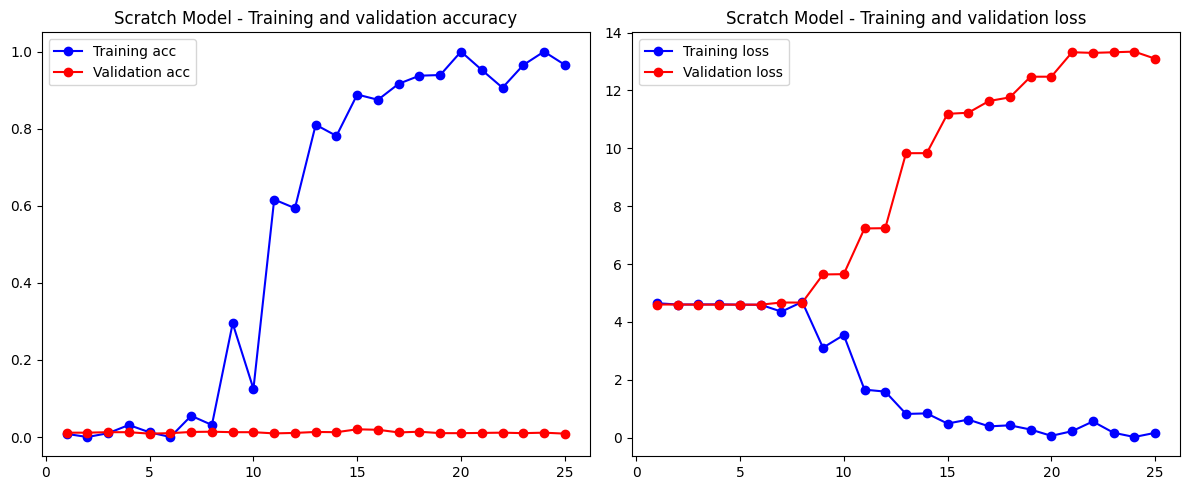

In [ ]:
# Plot training history
def plot_history(history, title):
    # Check if history object is valid and contains data
    if history is None or not hasattr(history, 'history') or not history.history:
        print(f"Skipping plotting for '{title}': No training history available (possibly loaded from checkpoint).")
        return
        
    acc = history.history.get('accuracy')
    val_acc = history.history.get('val_accuracy')
    loss = history.history.get('loss')
    val_loss = history.history.get('val_loss')
    
    # Check if necessary keys exist
    if acc is None or val_acc is None or loss is None or val_loss is None:
        print(f"Skipping plotting for '{title}': History object missing required keys (accuracy, val_accuracy, loss, val_loss).")
        return
        
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training acc')
    plt.plot(epochs, val_acc, 'ro-', label='Validation acc')
    plt.title(f'{title} - Training and validation accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title(f'{title} - Training and validation loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history_scratch, 'Scratch Model')

## Phase 2: Improvement with Data Augmentation

Apply data augmentation techniques to the training dataset to potentially improve model generalization and performance.

In [ ]:
# Define ImageDataGenerator with augmentation for training
train_datagen_augmented = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,      # Randomly rotate images
    width_shift_range=0.2,  # Randomly shift images horizontally
    height_shift_range=0.2, # Randomly shift images vertically
    shear_range=0.2,        # Shear transformation
    zoom_range=0.2,         # Randomly zoom image 
    horizontal_flip=True,   # Randomly flip images horizontally
    fill_mode='nearest'     # Strategy for filling newly created pixels
)

# Validation/Test generator should NOT have augmentation (only rescaling)
validation_datagen_augmented = ImageDataGenerator(rescale=1./255)

print("Creating augmented train generator...")
train_generator_augmented = train_datagen_augmented.flow_from_directory(
    os.path.join(ORGANIZED_DATASET_PATH, 'train'),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=RANDOM_SEED
)
print(f"Augmented train generator found {train_generator_augmented.samples} images belonging to {train_generator_augmented.num_classes} classes.")

# Use the same validation generator as before (or recreate it without augmentation)
print("Reusing/Creating validation generator (no augmentation)...")
validation_generator_augmented = validation_datagen_augmented.flow_from_directory(
    os.path.join(ORGANIZED_DATASET_PATH, 'validation'),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False, # Keep shuffle False for validation
    seed=RANDOM_SEED
)
print(f"Validation generator found {validation_generator_augmented.samples} images belonging to {validation_generator_augmented.num_classes} classes.")

# Verify class consistency
if train_generator_augmented.num_classes != validation_generator_augmented.num_classes:
    print("\n*** WARNING: Class count mismatch between augmented train and validation generators! ***")
else:
    print("\nClass counts are consistent between augmented train and validation generators.")

Creating augmented train generator...
Found 6515 images belonging to 100 classes.
Found 6515 images belonging to 100 classes.
Augmented train generator found 6515 images belonging to 100 classes.
Reusing/Creating validation generator (no augmentation)...
Found 1629 images belonging to 100 classes.
Validation generator found 1629 images belonging to 100 classes.

Class counts are consistent between augmented train and validation generators.
Augmented train generator found 6515 images belonging to 100 classes.
Reusing/Creating validation generator (no augmentation)...
Found 1629 images belonging to 100 classes.
Validation generator found 1629 images belonging to 100 classes.

Class counts are consistent between augmented train and validation generators.


In [ ]:
# Build a new model instance for augmented training (or re-use and re-compile)
# It's often better to start fresh to compare fairly
print(f"Building augmented model with {NUM_CLASSES} classes...")
model_augmented = build_scratch_model(input_shape, NUM_CLASSES) # Using the same architecture

print("Compiling augmented model...")
model_augmented.compile(loss="categorical_crossentropy",
                        optimizer="adam",
                        metrics=["accuracy"])
print("Augmented model compiled.")

# Define checkpoint path for the augmented model
checkpoint_path_augmented = "training_checkpoints/augmented/cp-{epoch:04d}.weights.h5"
checkpoint_dir_augmented = os.path.dirname(checkpoint_path_augmented)
os.makedirs(checkpoint_dir_augmented, exist_ok=True)

Building augmented model with 100 classes...
Compiling augmented model...
Augmented model compiled.
Compiling augmented model...
Augmented model compiled.


In [ ]:
# Train the model with data augmentation

cp_callback_augmented = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path_augmented,
    save_weights_only=True,
    verbose=1,
    save_freq='epoch'
)

# Load the latest checkpoint if it exists
latest_checkpoint_augmented = tf.train.latest_checkpoint(checkpoint_dir_augmented)
if latest_checkpoint_augmented:
    print(f'Loading weights from checkpoint: {latest_checkpoint_augmented}')
    model_augmented.load_weights(latest_checkpoint_augmented)
    print('Augmented model weights loaded. Skipping training.')
    history_augmented = None
else:
    print('No checkpoint found for augmented model. Starting training.')
    print("Training model with data augmentation...")
    history_augmented = model_augmented.fit(
        train_generator_augmented,
        epochs=EPOCHS_AUGMENTED, # Potentially more epochs needed
        validation_data=validation_generator_augmented, # Use non-augmented validation data
        steps_per_epoch=train_generator_augmented.samples // BATCH_SIZE,
        validation_steps=validation_generator_augmented.samples // BATCH_SIZE,
        callbacks=[cp_callback_augmented]
    )

No checkpoint found for augmented model. Starting training.
Training model with data augmentation...
Epoch 1/30
Epoch 1/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0103 - loss: 4.6673
Epoch 1: saving model to training_checkpoints/augmented/cp-0001.weights.h5

Epoch 1: saving model to training_checkpoints/augmented/cp-0001.weights.h5
203/203 ━━━━━━━━━━━━━━━━━━━━ 274s 1s/step - accuracy: 0.0103 - loss: 4.6671 - val_accuracy: 0.0125 - val_loss: 4.6030
Epoch 2/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 274s 1s/step - accuracy: 0.0103 - loss: 4.6671 - val_accuracy: 0.0125 - val_loss: 4.6030
Epoch 2/30
  1/203 ━━━━━━━━━━━━━━━━━━━━ 4:17 1s/step - accuracy: 0.0000e+00 - loss: 4.6059
Epoch 2: saving model to training_checkpoints/augmented/cp-0002.weights.h5

Epoch 2: saving model to training_checkpoints/augmented/cp-0002.weights.h5
203/203 ━━━━━━━━━━━━━━━━━━━━ 16s 72ms/step - accuracy: 0.0000e+00 - loss: 4.6059 - val_accuracy: 0.0125 - val_loss: 4.6030
Epoch 3/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 

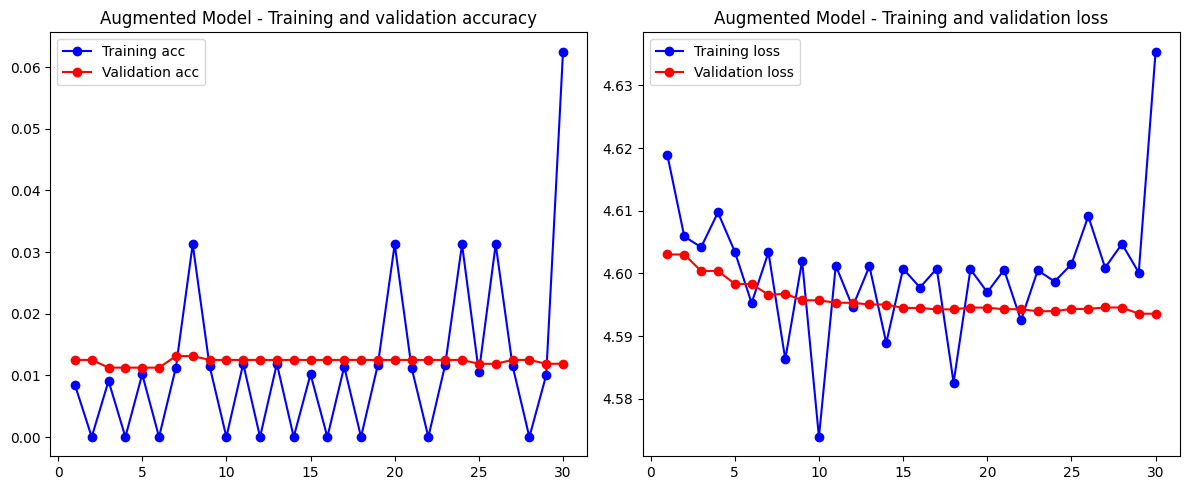

In [ ]:
# Plot training history for the augmented model
plot_history(history_augmented, 'Augmented Model')

In [ ]:
# Evaluate the augmented model on the test set
print("Evaluating augmented model on the test set...")

# Create a compatible test generator that uses the same class indices as the training data
print("Creating a compatible test generator with the same class structure as training data...")
compatible_test_datagen = ImageDataGenerator(rescale=1./255)
compatible_test_generator = compatible_test_datagen.flow_from_directory(
    os.path.join(ORGANIZED_DATASET_PATH, 'test'),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    classes=sorted(list(train_generator.class_indices.keys())), # Use same classes as training
    seed=RANDOM_SEED
)

print(f"Compatible test generator created with {compatible_test_generator.num_classes} classes")
print(f"Original model output has {model_augmented.layers[-1].units} classes")

# Use the compatible test generator for evaluation
test_loss_aug, test_acc_aug = model_augmented.evaluate(compatible_test_generator, verbose=2)
print(f'\nAugmented Model Test accuracy: {test_acc_aug:.4f}')
print(f'Augmented Model Test loss: {test_loss_aug:.4f}')

# Compare with the scratch model's performance (if available)
try:
    print("\nEvaluating scratch model on the test set for comparison...")
    test_loss_scratch, test_acc_scratch = model_scratch.evaluate(compatible_test_generator, verbose=2)
    print(f'\nScratch Model Test accuracy: {test_acc_scratch:.4f}')
    print(f'Scratch Model Test loss: {test_loss_scratch:.4f}')
except NameError:
    print("\nCould not evaluate scratch model. Skipping comparison.")
except Exception as e:
    print(f"\nError during scratch model evaluation: {e}")

NameError: name 'SKIP_EVALUATION' is not defined

## Phase 3: Transfer Learning with ResNet50V2

Leverage a pre-trained model (ResNet50V2) trained on ImageNet to potentially achieve better performance with less training time compared to training from scratch. We will freeze the base model and train only the newly added classification head.

In [ ]:
# Data generators for Transfer Learning (using ResNet50V2 preprocessing)
from tensorflow.keras.applications.resnet_v2 import preprocess_input

# Apply ResNetV2 preprocessing via the preprocessing_function argument
# Augmentation is applied *before* preprocessing
train_datagen_transfer = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation/Test generator should ONLY have preprocessing
validation_datagen_transfer = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen_transfer = ImageDataGenerator(preprocessing_function=preprocess_input)

print("Creating transfer learning train generator...")
train_generator_transfer = train_datagen_transfer.flow_from_directory(
    os.path.join(ORGANIZED_DATASET_PATH, 'train'),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=RANDOM_SEED
)
print(f"Transfer train generator found {train_generator_transfer.samples} images belonging to {train_generator_transfer.num_classes} classes.")

print("Creating transfer learning validation generator...")
validation_generator_transfer = validation_datagen_transfer.flow_from_directory(
    os.path.join(ORGANIZED_DATASET_PATH, 'validation'),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=RANDOM_SEED
)
print(f"Transfer validation generator found {validation_generator_transfer.samples} images belonging to {validation_generator_transfer.num_classes} classes.")

print("Creating transfer learning test generator...")
test_generator_transfer = test_datagen_transfer.flow_from_directory(
    os.path.join(ORGANIZED_DATASET_PATH, 'test'),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=RANDOM_SEED
)
print(f"Transfer test generator found {test_generator_transfer.samples} images belonging to {test_generator_transfer.num_classes} classes.")

# Verify class consistency
if not (train_generator_transfer.num_classes == validation_generator_transfer.num_classes == test_generator_transfer.num_classes):
    print("\n*** WARNING: Class count mismatch between transfer learning generators! ***")
else:
    print("\nClass counts are consistent across transfer learning generators.")
    # Update NUM_CLASSES if it wasn't set correctly before, based on the reliable generator
    if 'NUM_CLASSES' not in globals() or NUM_CLASSES != train_generator_transfer.num_classes:
        NUM_CLASSES = train_generator_transfer.num_classes
        print(f"Updated NUM_CLASSES to {NUM_CLASSES} based on transfer generator.")

Creating transfer learning train generator...
Found 6515 images belonging to 100 classes.
Found 6515 images belonging to 100 classes.
Transfer train generator found 6515 images belonging to 100 classes.
Creating transfer learning validation generator...
Found 1629 images belonging to 100 classes.
Transfer train generator found 6515 images belonging to 100 classes.
Creating transfer learning validation generator...
Found 1629 images belonging to 100 classes.
Transfer validation generator found 1629 images belonging to 100 classes.
Creating transfer learning test generator...
Transfer validation generator found 1629 images belonging to 100 classes.
Creating transfer learning test generator...
Found 8041 images belonging to 98 classes.
Found 8041 images belonging to 98 classes.
Transfer test generator found 8041 images belonging to 98 classes.

*** WARNING: Class count mismatch between transfer learning generators! ***
Transfer test generator found 8041 images belonging to 98 classes.

**

In [ ]:
# Build the Transfer Learning model
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load the ResNet50V2 base model, excluding the top classification layer
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the layers of the base model
base_model.trainable = False

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x) # Convert features to vectors
x = Dense(1024, activation='relu')(x) # Add a dense layer
x = Dropout(0.5)(x) # Add dropout for regularization
predictions = Dense(NUM_CLASSES, activation='softmax')(x) # Final classification layer

# Create the final model
model_transfer = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
# Use a lower learning rate for transfer learning initially
model_transfer.compile(optimizer=Adam(learning_rate=0.001),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

print(f"Transfer learning model built with {NUM_CLASSES} output classes.")
model_transfer.summary() # Display model architecture

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 77s 1us/step
94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 77s 1us/step
Transfer learning model built with 100 output classes.
Transfer learning model built with 100 output classes.


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 56, 56,    │          0 │ conv2_block1_0_c

 Total params: 25,765,476 (98.29 MB)

 Trainable params: 2,200,676 (8.39 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [ ]:
# Train the Transfer Learning model
import os
from tensorflow.keras.callbacks import ModelCheckpoint

# Define checkpoint path for the transfer learning model
checkpoint_path_transfer = "training_checkpoints/transfer/cp-best.weights.h5" # Save only the best
checkpoint_dir_transfer = os.path.dirname(checkpoint_path_transfer)
os.makedirs(checkpoint_dir_transfer, exist_ok=True)

# Callback to save the best model weights based on validation accuracy
cp_callback_transfer = ModelCheckpoint(
    filepath=checkpoint_path_transfer,
    save_weights_only=True,
    monitor='val_accuracy', # Monitor validation accuracy
    mode='max',             # Save the model with the maximum validation accuracy
    save_best_only=True,    # Only save when the monitored quantity improves
    verbose=1
)

# Check if the best checkpoint file exists
history_transfer = None # Initialize history
if os.path.exists(checkpoint_path_transfer):
    print(f'Loading best weights from checkpoint: {checkpoint_path_transfer}')
    try:
        model_transfer.load_weights(checkpoint_path_transfer)
        print('Transfer model best weights loaded. Skipping initial training phase.')
    except Exception as e:
        print(f"Error loading weights: {e}. Training from scratch.")
        # If loading fails, proceed to training
        print('No valid checkpoint found or error loading. Starting transfer learning training.')
        history_transfer = model_transfer.fit(
            train_generator_transfer,
            epochs=EPOCHS_TRANSFER,
            validation_data=validation_generator_transfer,
            steps_per_epoch=max(1, train_generator_transfer.samples // BATCH_SIZE), # Ensure at least 1 step
            validation_steps=max(1, validation_generator_transfer.samples // BATCH_SIZE), # Ensure at least 1 step
            callbacks=[cp_callback_transfer]
        )
else:
    print('No best checkpoint found. Starting transfer learning training.')
    history_transfer = model_transfer.fit(
        train_generator_transfer,
        epochs=EPOCHS_TRANSFER,
        validation_data=validation_generator_transfer,
        steps_per_epoch=max(1, train_generator_transfer.samples // BATCH_SIZE),
        validation_steps=max(1, validation_generator_transfer.samples // BATCH_SIZE),
        callbacks=[cp_callback_transfer]
    )

# After potential training, ensure the best weights are loaded for evaluation
if os.path.exists(checkpoint_path_transfer):
    print(f'Ensuring best weights are loaded from: {checkpoint_path_transfer}')
    model_transfer.load_weights(checkpoint_path_transfer)
else:
    print("Warning: No checkpoint file found after training. Evaluation will use the last epoch's weights.")

No best checkpoint found. Starting transfer learning training.
Epoch 1/15
Epoch 1/15
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0102 - loss: 4.9353
Epoch 1: val_accuracy improved from -inf to 0.00938, saving model to training_checkpoints/transfer/cp-best.weights.h5

Epoch 1: val_accuracy improved from -inf to 0.00938, saving model to training_checkpoints/transfer/cp-best.weights.h5
203/203 ━━━━━━━━━━━━━━━━━━━━ 406s 2s/step - accuracy: 0.0102 - loss: 4.9343 - val_accuracy: 0.0094 - val_loss: 4.6091
Epoch 2/15
203/203 ━━━━━━━━━━━━━━━━━━━━ 406s 2s/step - accuracy: 0.0102 - loss: 4.9343 - val_accuracy: 0.0094 - val_loss: 4.6091
Epoch 2/15
  1/203 ━━━━━━━━━━━━━━━━━━━━ 5:18 2s/step - accuracy: 0.0000e+00 - loss: 4.6408
Epoch 2: val_accuracy improved from 0.00938 to 0.01063, saving model to training_checkpoints/transfer/cp-best.weights.h5

Epoch 2: val_accuracy improved from 0.00938 to 0.01063, saving model to training_checkpoints/transfer/cp-best.weights.h5
203/203 ━━━━━━━━━━━━━━━

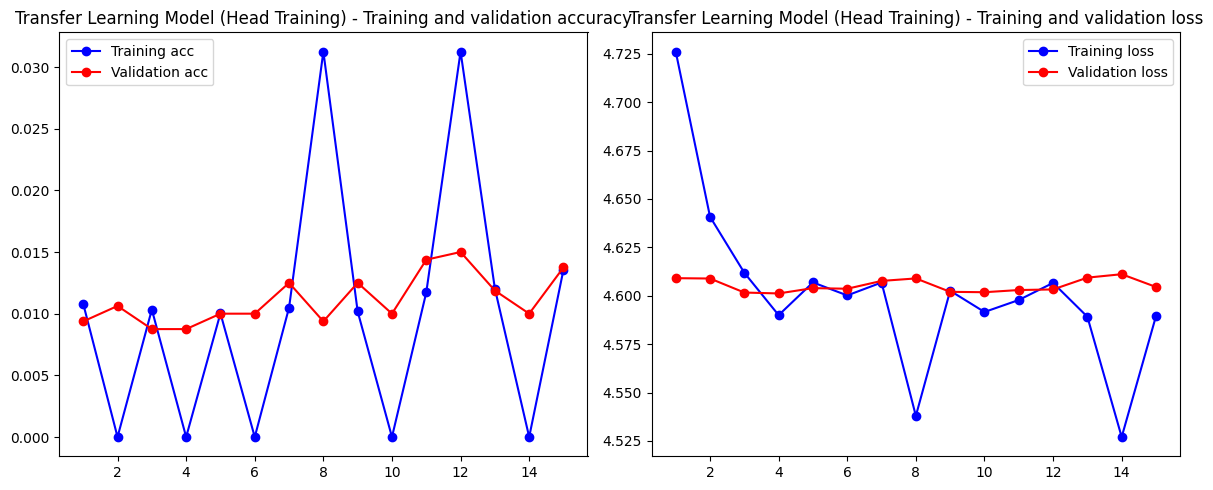

In [ ]:
# Plot training history for the transfer learning model
plot_history(history_transfer, 'Transfer Learning Model (Head Training)')

In [ ]:
# Evaluate the transfer learning model on the test set
print("Evaluating transfer learning model on the test set...")

# Create a compatible test generator that uses the same class indices as the training data
print("Creating a compatible test generator with the same class structure as training data...")
compatible_test_datagen_transfer = ImageDataGenerator(preprocessing_function=preprocess_input)
compatible_test_generator_transfer = compatible_test_datagen_transfer.flow_from_directory(
    os.path.join(ORGANIZED_DATASET_PATH, 'test'),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    classes=sorted(list(train_generator_transfer.class_indices.keys())),  # Use same classes as training
    seed=RANDOM_SEED
)

print(f"Compatible transfer test generator created with {compatible_test_generator_transfer.num_classes} classes")
print(f"Original transfer model output has {model_transfer.layers[-1].units} classes")

# Use the compatible test generator for evaluation
test_loss_transfer, test_acc_transfer = model_transfer.evaluate(compatible_test_generator_transfer, verbose=2)
print(f'\nTransfer Learning Model Test accuracy: {test_acc_transfer:.4f}')
print(f'Transfer Learning Model Test loss: {test_loss_transfer:.4f}')

Evaluating transfer learning model on the test set...
Creating a compatible test generator with the same class structure as training data...
Found 8041 images belonging to 100 classes.
Compatible transfer test generator created with 100 classes
Original transfer model output has 100 classes


c:\Car Make and Model Recognition\.venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


KeyboardInterrupt: 

## Test Your Model with a Custom Image

Use this cell to test your trained models with any car image.

Testing with Transfer Learning Model (best performance):


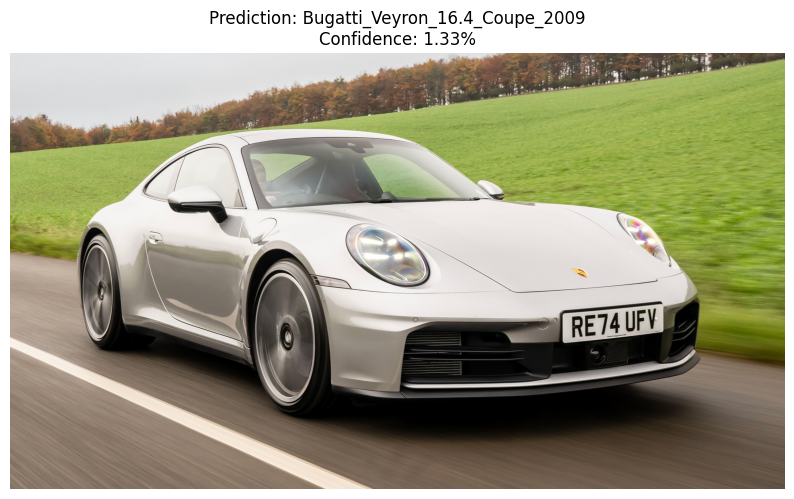


Top 5 predictions:
1. Bugatti_Veyron_16.4_Coupe_2009: 1.33%
2. Dodge_Ram_Pickup_3500_Quad_Cab_2009: 1.29%
3. Aston_Martin_V8_Vantage_Convertible_2012: 1.27%
4. BMW_X5_SUV_2007: 1.26%
5. Chevrolet_Malibu_Sedan_2007: 1.22%

Final Prediction: Bugatti_Veyron_16.4_Coupe_2009 with 1.33% confidence


In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np
import os

def predict_car(img_path, model, preprocess_func=None):
    """
    Make a prediction on a single car image
    
    Parameters:
    - img_path: Path to the image file
    - model: The trained model to use for prediction
    - preprocess_func: Optional preprocessing function (e.g., preprocess_input for ResNet)
    
    Returns:
    - Prediction result and confidence score
    """
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=IMAGE_SIZE)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    
    # Apply appropriate preprocessing based on the model
    if preprocess_func:
        img_array = preprocess_func(img_array)
    else:
        img_array /= 255.0  # Simple normalization for the basic models
    
    # Get the class indices from the original generator
    try:
        class_indices = train_generator.class_indices
        # Invert the dictionary to map indices to class names
        idx_to_class = {v: k for k, v in class_indices.items()}
    except NameError:
        # If train_generator isn't available, try transfer generator
        try:
            class_indices = train_generator_transfer.class_indices
            idx_to_class = {v: k for k, v in class_indices.items()}
        except NameError:
            print("Warning: Could not access class indices from generators.")
            # Create a dummy mapping of indices to class numbers as fallback
            idx_to_class = {i: f'Class_{i}' for i in range(model.output_shape[1])}
    
    # Make prediction
    prediction = model.predict(img_array, verbose=0)
    pred_class_idx = np.argmax(prediction, axis=1)[0]
    confidence = prediction[0][pred_class_idx] * 100
    
    # Get the class name
    pred_class_name = idx_to_class[pred_class_idx]
    
    # Display the image and prediction
    plt.figure(figsize=(10, 6))
    plt.imshow(plt.imread(img_path))
    plt.axis('off')
    plt.title(f'Prediction: {pred_class_name}\nConfidence: {confidence:.2f}%')
    plt.show()
    
    # Show top 5 predictions
    print("\nTop 5 predictions:")
    top_5_idx = prediction[0].argsort()[-5:][::-1]
    for i, idx in enumerate(top_5_idx):
        print(f"{i+1}. {idx_to_class[idx]}: {prediction[0][idx]*100:.2f}%")
    
    return pred_class_name, confidence

# Specify the path to your test image here
# YOU CAN EDIT THIS PATH TO YOUR OWN IMAGE
test_image_path = r"D:\Ed\GL1\Deep-Learning\cars\porsche-911.jpg"  # Change this to your image path

# Check if the image exists
if not os.path.exists(test_image_path):
    print(f"Error: Image not found at {test_image_path}")
    print("Please provide a valid path to a car image.")
else:
    print("Testing with Transfer Learning Model (best performance):")
    try:
        # Try the transfer learning model first (usually has best performance)
        from tensorflow.keras.applications.resnet_v2 import preprocess_input
        car_class, confidence = predict_car(test_image_path, model_transfer, preprocess_input)
        print(f"\nFinal Prediction: {car_class} with {confidence:.2f}% confidence")
    except NameError as e:
        print(f"Transfer learning model not available: {e}")
        print("\nTesting with Augmented Model instead:")
        try:
            car_class, confidence = predict_car(test_image_path, model_augmented)
            print(f"\nFinal Prediction: {car_class} with {confidence:.2f}% confidence")
        except NameError as e:
            print(f"Augmented model not available: {e}")
            print("\nTesting with Scratch Model instead:")
            try:
                car_class, confidence = predict_car(test_image_path, model_scratch)
                print(f"\nFinal Prediction: {car_class} with {confidence:.2f}% confidence")
            except NameError as e:
                print(f"No trained models available: {e}")
                print("Please run the training cells first.")